# First Approach - XGRegressor

17/11/2025

## Import Modules

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import xgboost

## Import Data

In [25]:
data = pd.read_csv("data_20251117.csv", sep=";")

data.head(5)

,Classe,Nom,MS % brut,PB % brut,CB % brut,MGR % brut,MM % brut,NDF % brut,ADF % brut,Lignine % brut,...,Sucres % brut,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,Céréales,Blé,90.800003,8.0,2.0,1.2,1.3,11.4,2.8,0.9,...,2.6,3900,3470,3380,2660,3060,2940,1.09,74,-40.0
1,Céréales,Blé,90.000000,8.0,1.9,1.2,1.4,11.0,2.7,0.9,...,2.6,3860,3450,3360,2640,3040,2920,1.08,73,-39.0
2,Céréales,Blé,89.000000,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3820,3410,3320,2610,2980,2870,1.07,73,-38.0
3,Céréales,Blé,88.800003,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3810,3400,3310,2600,2980,2860,1.07,73,-37.0
4,Céréales,Blé,88.500000,8.0,2.3,1.2,1.6,12.5,3.2,1.0,...,2.6,3790,3320,3230,2550,3000,2880,1.05,72,-36.0


In [26]:
colonnes = data.columns
colonnes_X = list(colonnes[:12])
colonnes_Y = list(colonnes[12:])

print(colonnes_X)
print(colonnes_Y)

colonnes_cat = colonnes_X[:2]
colonnes_num = colonnes_X[2:]

['Classe', 'Nom', 'MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']
['EB (kcal) kcal/kg brut', 'ED porc croissance (kcal) kcal/kg brut', 'EM porc croissance (kcal) kcal/kg brut', 'EN porc croissance (kcal) kcal/kg brut', 'EMAn coq (kcal) kcal/kg brut', 'EMAn poulet (kcal) kcal/kg brut', 'UFL 2018 par kg brut', 'PDI 2018 g/kg brut', 'BalProRu 2018 g/kg brut']


In [27]:
X = data[colonnes_X].values
y = data[colonnes_Y].values

X_cat = data[colonnes_cat].values
X_num = data[colonnes_num].values

## Affichage des boxplots pour les descripteurs numériques

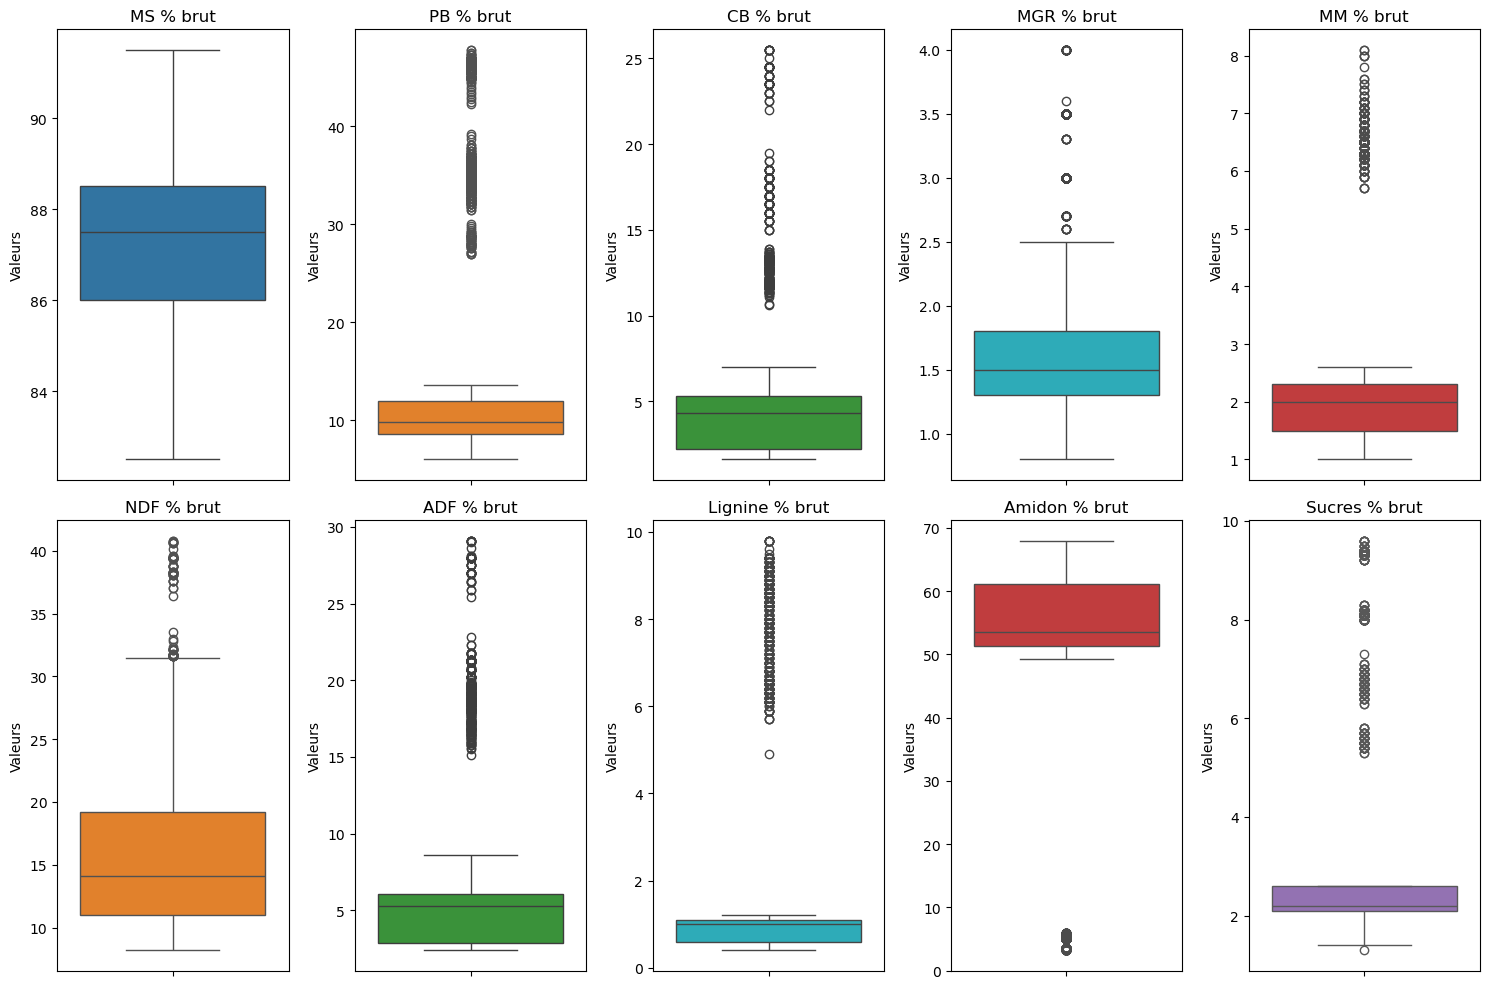

In [28]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(15, 10))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red', 'tab:purple']
num_col = 0

for k in range(2):
    for l in range(5):
        
        ax = axes[k,l]
        color = colors[l+k]
        array = X_num[:, num_col]

        sns.boxplot(y=array, ax=ax, color=color)
        ax.set_xlabel("")  # pas pertinent ici
        ax.set_ylabel("Valeurs")
        ax.set_title(colonnes_num[num_col])
        ax.tick_params(axis='x', labelbottom=False)  # Pas de labels x
        num_col +=1
plt.tight_layout()
plt.show()

## Affichage des histogrammes pour les valeurs catégorielles

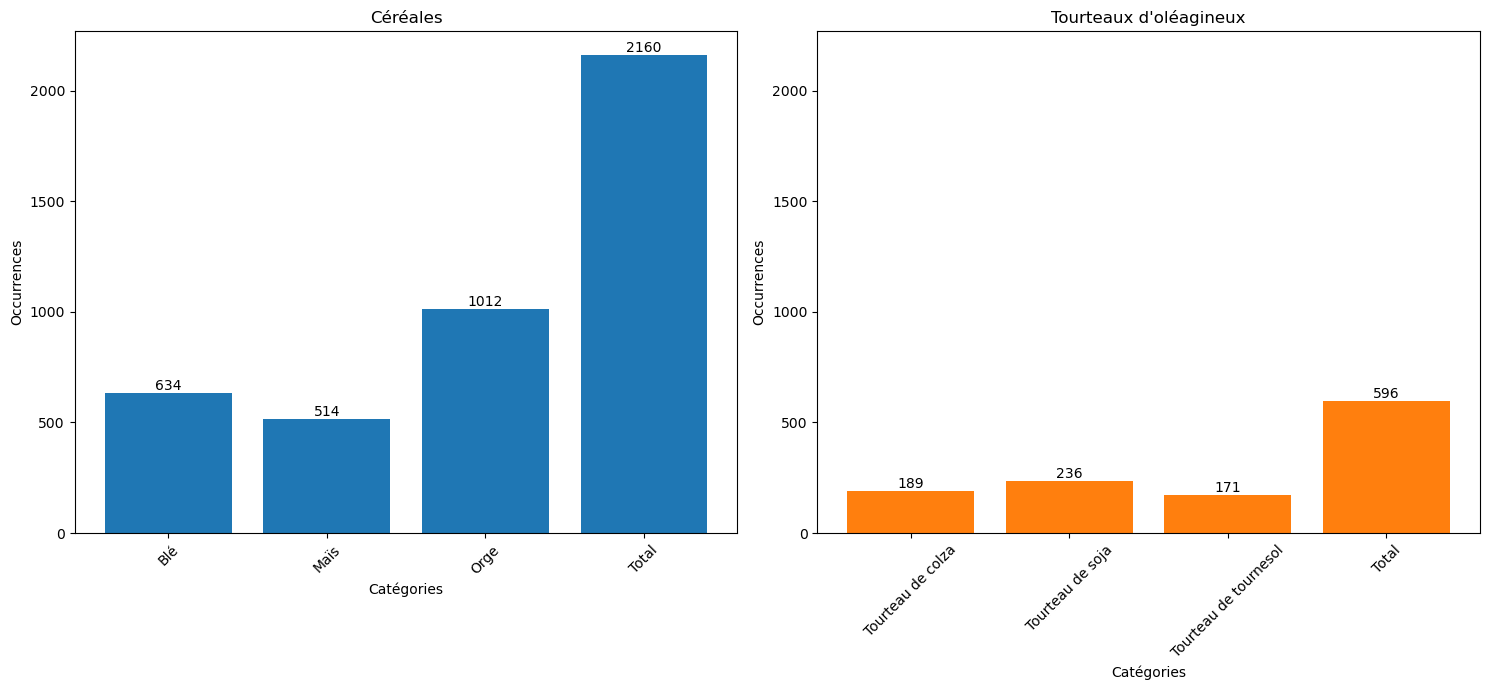

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
colors = ['tab:blue', 'tab:orange', 'tab:green']
unique_classe, counts_classe = np.unique(X_cat[:,0], return_counts=True)
unique_nom, counts_nom = np.unique(X_cat[:,1], return_counts=True)
ylim = int(max(counts_classe)*1.05)

for k in range(2):
    ax = axes[k]
    color = colors[k]

    index = np.where(X_cat[:,0] == unique_classe[k])[0]
    array = X_cat[index, 1]
    unique, counts = np.unique(array, return_counts=True)

    # Ajout du total
    unique = np.concatenate([unique, np.array(["Total"])])
    counts = np.concatenate([counts, np.array([counts_classe[k]])])

    ax.bar(unique, counts, color=color)
    ax.set_ylim(0, ylim + 1)
    ax.set_xlabel("Catégories")
    ax.set_ylabel("Occurrences")
    ax.set_title(unique_classe[k])
    ax.tick_params(axis='x', rotation=45)

    # === Ajout des valeurs au-dessus de chaque barre ===
    for i, val in enumerate(counts):
        ax.text(i, val + 0.1, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## One Hot encoding des variables catégorielles

In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

stockage = np.zeros((X_cat.shape[0],1))

for k in range(X_cat.shape[1]):
    encoded = encoder.fit_transform(X_cat[:,k].reshape(-1,1))
    stockage = np.concatenate((stockage,encoded), axis=1)

X_encoded = stockage[:,1:]
colonnes_encoded = list(unique_classe)+list(unique_nom)

print(X_encoded[:10])
print(colonnes_encoded)

[[1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]]
['Céréales', "Tourteaux d'oléagineux", 'Blé', 'Maïs', 'Orge', 'Tourteau de colza', 'Tourteau de soja', 'Tourteau de tournesol']


In [31]:
X_tot_enc = np.concatenate((X_encoded, X_num), axis=1)
colonnes_tot_enc = colonnes_encoded+colonnes_num

print(colonnes_tot_enc)
print(X_tot_enc[:2])

['Céréales', "Tourteaux d'oléagineux", 'Blé', 'Maïs', 'Orge', 'Tourteau de colza', 'Tourteau de soja', 'Tourteau de tournesol', 'MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']
[[ 1.          0.          1.          0.          0.          0.
   0.          0.         90.80000305  8.          2.          1.20000005
   1.29999995 11.39999962  2.79999995  0.89999998 65.09999847  2.5999999 ]
 [ 1.          0.          1.          0.          0.          0.
   0.          0.         90.          8.          1.89999998  1.20000005
   1.39999998 11.          2.70000005  0.89999998 64.69999695  2.5999999 ]]


## Définition des ensembles de tests et d'apprentissage

Ratio Train/Test 0.7/0.3

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test,\
    y_train, y_test, \
          = train_test_split(X_tot_enc,y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(1929, 18)
(827, 18)


### Définition des fonctions d'évaluation du modèle

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluation_regression(model, X_train, X_test, y_train, y_test, model_name = ""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("")
    print(f'Essai sur échantillon de test {model_name}')
    print("y_pred min/max :", round(y_pred.min(),3), round(y_pred.max(),3))
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return [model_name,mae,rmse,r2]

#### Création du tableau de stockage des résultats

In [34]:
df = pd.DataFrame(columns=["Model_name","MAE", "RMSE", "R2"])

## Execution et évaluation des modèles

In [35]:
from xgboost import XGBRegressor
# XGBRegressor

model_xgb_tot = XGBRegressor()

df.loc[len(df)] =evaluation_regression(model_xgb_tot, X_train, X_test, y_train, y_test,"XGBRegressor_tot")


Essai sur échantillon de test XGBRegressor_tot
y_pred min/max : -56.391 4225.508
MAE: 4.098 | RMSE: 7.298 | R²: 0.999


## Evaluation des résultats : 

- MAE : Mean Average Error
- RMSE : Root Mean Square Error
- R²

In [36]:
print(df)

         Model_name       MAE      RMSE        R2
0  XGBRegressor_tot  4.097652  7.298484  0.999122


# Test pour mauvaises valeurs

Permet d'évaluer si les modèles ne possèdent pas de fuite de données quelquonque.
Nous essayons ici de prédire ce que nous avons jamais vu.

L'ensemble d'apprentissage contient toutes les céréales tandis que le test que les oléagineux.

In [37]:
X_train_false = X_tot_enc[np.where(X_tot_enc[:,0] ==1)[0]]
X_test_false = X_tot_enc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_false = y[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_false = y[np.where(X_tot_enc[:,0] ==0)[0]]

## Execution et évaluation des modèles

In [38]:
# XGBRegressor
model_xgb_tot_false = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_tot_false, X_train_false, X_test_false, y_train_false, y_test_false,"XGBRegressor_tot_false")


Essai sur échantillon de test XGBRegressor_tot_false
y_pred min/max : 0.954 3978.652
MAE: 409.162 | RMSE: 572.142 | R²: -8.233


## Evaluation des résultats : 

- MAE : Mean Average Error
- RMSE : Root Mean Square Error
- R²

In [39]:
df

,Model_name,MAE,RMSE,R2
0,XGBRegressor_tot,4.097652,7.298484,0.999122
1,XGBRegressor_tot_false,409.161782,572.141639,-8.233281


# Evaluation pour une nouvelle valeur 

BLE TENDRE MS 86.89 MAT 10.96 CB 2.39 MM 1.54 MGR 1.37 NDF 12.78 ADF 3.28 LIGNINE 1.05 AMIDON 60 SUCRES 2.62

Avoine MS 87.64, MAT 9.44 CB 11.66 MM 2.54 MGR 4.70 NDF 31.58 ADF 14.44 LIGN 2.32 AMIDON 36.72 SUCRES 1.32
AVOINE ED PORC 2658.983 EM 2559.276 EN 1920.345 EM COQ 2356.448 EM POULET 2231.005

In [40]:
instance_X = X_test[10]
instance_y = y_test[10]

print("Longueur X 13 =", len(instance_X))
print("Longueur y 5 =", len(instance_y))

Longueur X 13 = 18
Longueur y 5 = 9


In [41]:
y_chap_tot = model_xgb_tot.predict([instance_X])
df_ychap = pd.DataFrame(columns=colonnes_Y)

df_ychap.loc[len(df_ychap)] = instance_y
df_ychap.loc[len(df_ychap)] = y_chap_tot[0]

df_ychap.T

,0,1
EB (kcal) kcal/kg brut,4040.00,4058.759033
ED porc croissance (kcal) kcal/kg brut,2800.00,2861.391846
EM porc croissance (kcal) kcal/kg brut,2580.00,2598.772949
EN porc croissance (kcal) kcal/kg brut,1570.00,1595.106445
EMAn coq (kcal) kcal/kg brut,1580.00,1593.388428
EMAn poulet (kcal) kcal/kg brut,1400.00,1415.026733
UFL 2018 par kg brut,0.85,0.868683
PDI 2018 g/kg brut,128.00,130.431961
BalProRu 2018 g/kg brut,157.00,157.140472
